In [45]:
import sklearn.tree
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from timeit import default_timer as timer
from collections import Counter
import itertools
import joblib

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

SECONDS_PER_CHAOS = 150
ITEMTYPE = 'ring'

# Import / Preprocess Data

In [46]:
features_pd = pd.read_csv(ITEMTYPE + '_features_1c.csv.bz2', compression='bz2')
features_pd.rename(columns={'Price':'price'}, inplace=True)
# Remove some items from the dataset because manual inspection showed that they're worthless
# and people probably just set such a high price because they used their public tab as storage space
# and didn't want trade requests for the item.
BLACKLIST = [
    232645, 50583, 54771, 41170, 187705, 90734, 75154, 230283, 202346, 202233, 192351, 189673, 184245, 172352,
    154553, 20503, 252668, 148156, 204343, 205422, 167712, 142688, 135112, 118769, 101033, 59304, 53361, 128636,
    114791, 96567, 185723, 241982, 239532, 226390, 218090, 215806, 199539, 74950, 55204, 53152, 29227, 22729,
    71370
]
features_pd = features_pd.loc[features_pd['Unnamed: 0'].apply(lambda x: x not in BLACKLIST)]

prices_pd = features_pd['price']
targets_pd = prices_pd.apply(lambda x: 1 if x > 0 else 0)
full_pd = features_pd.copy()
full_pd['valuable'] = targets_pd
full_pd['price'] = prices_pd

features_pd = full_pd
#features_pd = full_pd[[x for x in full_pd.columns if x not in ['valuable', 'price', 'Unnamed: 0']]]
#columns = [x + '/' + y for x, y in itertools.combinations(features_pd.columns, 2)] + ['valuable', 'price']
#values = []
#for i, row in features_pd.iterrows():
#    price = prices_pd[i]
#    valuable = 1 if price > 0 else 0
#    values.append([x*y for x,y in itertools.combinations(row, 2)] + [valuable, price])
#features_pd = pd.DataFrame(data=values, columns=columns)
#values = columns = None
    
print(features_pd.shape)

print("Max Price:", features_pd['price'].max())
print("Average Price:", features_pd['price'].mean())

num_total = features_pd.shape[0]
num_valuable = features_pd['valuable'].sum()
num_worthless = num_total - num_valuable
print("Num valuable: {} ({}%)".format(num_valuable, (num_valuable / num_total) * 100))
print("Num worthless: {} ({}%)".format(num_worthless, (num_worthless / num_total) * 100))

(254394, 41)
Max Price: 104526
Average Price: 12.4583991761
Num valuable: 129278 (50.81802243763611%)
Num worthless: 125116 (49.18197756236389%)


# Generic Helper Functions

In [38]:
def print_item(item):
    for column in item.index:
        if item[column] > 0:
            print("  {}: {}".format(column, item[column]))

In [39]:
def format_time(seconds):
    s = seconds%60
    m = (seconds//60)%60
    h = seconds//3600
    return "{}h {}m {}s".format(h,m,s)

def evaluate_predictions(predictions, actual_y, prices):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    invalid_stuff = 0
    playtime_saved = 0
    playtime_wasted = 0
    wasted_by_currency = Counter()
    count_by_currency = Counter()
    for actual, predicted, p in zip(actual_y, predictions, prices):
        count_by_currency[p] += 1
        if actual == 1 and predicted == 1:
            true_positives += 1
            playtime_saved += 10
        elif actual == 0 and predicted == 0:
            true_negatives += 1
            # This doesn't save time, player still has to price-check
        elif actual == 0 and predicted == 1:
            false_positives += 1
            # This doesn't waste time, player would do this without the tool anyway
        elif actual == 1 and predicted == 0:
            false_negatives += 1
            playtime_wasted += p * 150
            wasted_by_currency[p] += 1
        else:
            invalid_stuff += 1

    valuable_percent = sum(actual_y) / len(actual_y)
    playtime_saved = playtime_saved / valuable_percent * 0.05
    playtime_wasted = playtime_wasted * valuable_percent * 0.05

    manual_sort_time = (len(actual_y) - sum(actual_y)) * 10 + sum(actual_y) * 30
    assisted_sort_time = false_positives * 10 + (sum(predictions) - false_positives) * 30

    print("Valuable Items Wasted: {} ({:.1f}%)".format(false_negatives, 100*(false_negatives / (false_negatives + true_positives))))
    print("Worthless Items Kept: {} ({:.1f}%)".format(false_positives, 100*(false_positives / (false_positives + true_negatives))))

    #print("Playtime Saved at 95% Junk:", format_time(playtime_saved))
    #print("Playtime Wasted at 95% Junk:", format_time(playtime_wasted))

    #print("Manual Sort Time:", format_time(manual_sort_time / valuable_percent * 0.05))
    #print("Assisted Sort Time:", format_time(assisted_sort_time / valuable_percent * 0.05))
    #print("Currency Wasted:", playtime_wasted / 300, "Chaos")
    
    cph = playtime_wasted / playtime_saved * 3600 / SECONDS_PER_CHAOS
    print("Currency wasted per hour of saved sort time: {:.1f} chaos".format(cph))
    print()
    print("Items wasted by currency:")
    for k,v in sorted(wasted_by_currency.items()):
        percent = v / count_by_currency[k]
        print("{:5} chaos: {:6} ({:.1%})".format(k,v,percent))

In [42]:
def print_false_negatives(features, predictions, how_many):
    false_negatives = [x for (i,x),p in zip(features.iterrows(), predictions) if p == 0 and x['price'] > 0]
    false_negatives.sort(key=lambda x: x['price'])
    for item in false_negatives[-how_many:]:
        print('-------------------------------')
        print_item(item)
print_false_negatives(dtest, model.predict(dtest[predictors]), 20)        

-------------------------------
  Unnamed: 0: 9071
  Accuracy: 208
  AddedColdAttackDamage: 32
  Corrupted: 1
  DoubledInBreach: 1
  EnergyShield: 28
  Life: 95
  price: 70
  Strength: 35
  TotalEleResist: 24
  valuable: 1
-------------------------------
  Unnamed: 0: 71370
  Accuracy: 14
  AddedPhysAttackDamage: 14
  EnergyShield: 19
  price: 70
  TotalEleResist: 43
  valuable: 1
-------------------------------
  Unnamed: 0: 22729
  AddedColdAttackDamage: 17
  AddedFireAttackDamage: 34
  AddedLightningAttackDamage: 44
  Dexterity: 24
  HasSocket: 1
  price: 78
  valuable: 1
-------------------------------
  Unnamed: 0: 29227
  AddedFireAttackDamage: 27
  Corrupted: 1
  DoubledInBreach: 1
  EnergyShield: 6
  ItemRarity: 14
  LifeRegen: 47
  price: 78
  TotalEleResist: 9
  valuable: 1
-------------------------------
  Unnamed: 0: 53152
  Accuracy: 14
  Life: 22
  Mana: 39
  ManaRegen: 13
  price: 78
  TotalEleResist: 14
  valuable: 1
-------------------------------
  Unnamed: 0: 55204
 

---------------
# xgBoost

## xgBoost Functions

In [32]:
def duplicate_false_negatives_xgb(threshold):
    global dtrain

    num_fn = 0
    num_tp = 0
    false_negatives = []
    predictions_train = model.predict(dtrain[predictors])
    for i, (y, pred, price) in enumerate(zip(dtrain['valuable'], predictions_train, dtrain['price'])):
        if y == 1 and pred == 0 and price >= threshold:
            num_fn += 1
            false_negatives.append(dtrain.iloc[i])
        elif y == 1 and pred == 1 and price >= threshold:
            num_tp += 1
        
    dtrain = dtrain.append(false_negatives)
    return num_fn, num_tp

In [33]:
def modelfit_xgb(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])

def show_model_stats(alg, dtrain, predictors, target):
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## xgBoost Setup

In [47]:
tmask = np.random.choice([False,True], features_pd.shape[0], p=[0.25, 0.75])
vmask = np.invert(tmask)
dtrain = features_pd[tmask]
dtest = features_pd[vmask]

predictors = [x for x in features_pd.columns if x not in ['price','valuable','Unnamed: 0']]

xgb_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth':9, 'min_child_weight':6, 'gamma':0.15,
              'seed':41083, 'subsample': 0.8, 'colsample_bytree':0.9, 'objective':'binary:logistic', 
              'scale_pos_weight':1}
model = xgb.XGBClassifier(**xgb_params)

## xgBoost Bad-Dog-Training

False negatives (10c+): 2047 (13.8%)
False negatives (20c+): 668 (7.6%)
False negatives (30c+): 677 (10.5%)
False negatives (40c+): 926 (17.3%)
False negatives (50c+): 1068 (20.8%)
False negatives (50c+): 640 (9.6%)
False negatives (50c+): 271 (3.5%)
Bad Dog Training done after 0.0h 10.0m 2.791922751996026s

Model Report
Accuracy : 0.6904
AUC Score (Train): 0.759959
Valuable Items Wasted: 11725 (36.2%)
Worthless Items Kept: 9707 (31.0%)
Currency wasted per hour of saved sort time: 154.8 chaos

Items wasted by currency:
    1 chaos:   6753 (48.7%)
    2 chaos:   1481 (37.8%)
    3 chaos:    810 (33.9%)
    4 chaos:    346 (28.5%)
    5 chaos:   1417 (34.9%)
    6 chaos:     73 (19.6%)
    7 chaos:     51 (18.1%)
    8 chaos:     74 (17.8%)
    9 chaos:     32 (20.3%)
   10 chaos:    476 (28.7%)
   11 chaos:      1 (2.7%)
   12 chaos:     13 (9.1%)
   13 chaos:      9 (12.7%)
   15 chaos:     60 (10.3%)
   16 chaos:      1 (4.8%)
   17 chaos:     13 (18.6%)
   18 chaos:      2 (5.7%)
   

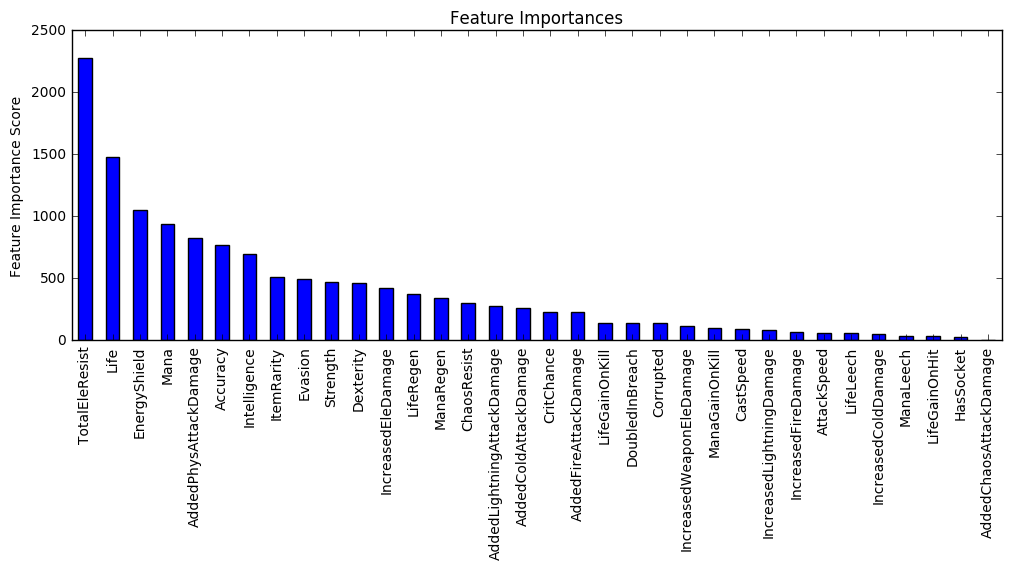

In [48]:
start = timer()

# Refine model by duplicating all valuable false negatives until they are properly detected
for t in [10,20,30,40,50,50,50,50,50,50]:
    modelfit_xgb(model, dtrain, predictors, 'valuable')
    num_fn, num_total = duplicate_false_negatives_xgb(t)
    print("False negatives ({}c+): {} ({:.1f}%)".format(t, num_fn, (num_fn / num_total) * 100))
    if t >= 50 and num_fn / num_total < 0.05:
        break

print("Bad Dog Training done after", format_time(timer() - start))        
show_model_stats(model, dtrain, predictors, 'valuable')        
evaluate_predictions(model.predict(dtest[predictors]), dtest['price'].apply(lambda x: x > 0), dtest['price'])

## xgBoost Final Model

In [49]:
start = timer()

#dtrain = dtrain.loc[dtrain['Unnamed: 0'].apply(lambda x: x not in BLACKLIST)]

final_params = {**xgb_params}
final_params['learning_rate'] = 0.01
final_params['n_estimators'] = 1000
model = xgb.XGBClassifier(**final_params)
modelfit_xgb(model, dtrain, predictors, 'valuable')

print("Final model trained after", format_time(timer() - start))

evaluate_predictions(model.predict(dtest[predictors]), dtest['price'].apply(lambda x: x > 0), dtest['price'])
joblib.dump(model, './' + ITEMTYPE + ".model")

Final model trained after 0.0h 13.0m 55.84014190400194s
Valuable Items Wasted: 11603 (35.9%)
Worthless Items Kept: 9731 (31.1%)
Currency wasted per hour of saved sort time: 151.6 chaos

Items wasted by currency:
    1 chaos:   6688 (48.2%)
    2 chaos:   1449 (37.0%)
    3 chaos:    803 (33.6%)
    4 chaos:    345 (28.4%)
    5 chaos:   1401 (34.5%)
    6 chaos:     79 (21.2%)
    7 chaos:     50 (17.7%)
    8 chaos:     77 (18.5%)
    9 chaos:     27 (17.1%)
   10 chaos:    480 (28.9%)
   11 chaos:      1 (2.7%)
   12 chaos:      9 (6.3%)
   13 chaos:      9 (12.7%)
   14 chaos:      1 (1.9%)
   15 chaos:     62 (10.7%)
   16 chaos:      1 (4.8%)
   17 chaos:     13 (18.6%)
   18 chaos:      1 (2.9%)
   19 chaos:      4 (18.2%)
   20 chaos:     34 (6.8%)
   22 chaos:      1 (2.4%)
   23 chaos:      1 (12.5%)
   24 chaos:      2 (18.2%)
   25 chaos:     10 (3.9%)
   28 chaos:      1 (5.9%)
   29 chaos:      2 (20.0%)
   30 chaos:      8 (2.8%)
   35 chaos:      2 (1.6%)
   40 chaos:   

['./ring.model']

## Tweak xgBoost Parameters

In [ ]:
cv_params = {'max_depth': [7,9,11]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth':9, 'min_child_weight':6, 'gamma':0.15,
              'seed':41083, 'subsample': 0.8, 'colsample_bytree':0.9, 'objective':'binary:logistic', 
              'scale_pos_weight':1}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), param_grid=cv_params, cv=5, n_jobs=4, iid=False, verbose=1)
start = timer()
optimized_GBM.fit(dtrain[predictors], dtrain[target])
deltaTime = timer() - start
s = deltaTime % 60           
m = (deltaTime // 60) % 60  
h = deltaTime // 3600      
print("Training done after {}h {}m {}s".format(h,m,s))

In [ ]:
optimized_GBM.grid_scores_, optimized_GBM.best_params_, optimized_GBM.best_score_

# Neural Network 

In [ ]:
from sklearn.model_selection import train_test_split
features_pd = full_pd[[x for x in full_pd.columns if x not in ['valuable', 'Unnamed: 0']]]
targets_pd = full_pd['valuable']
X_train, X_test, y_train, y_test = train_test_split(features_pd, targets_pd)
p_train = X_train['price']
p_test = X_test['price']
X_train = X_train.drop('price', axis=1)
X_test = X_test.drop('price', axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,30), warm_start=True)

def train_model():
    mlp.fit(X_train,y_train)

In [ ]:
train_model()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions_train = mlp.predict(X_train)
predictions = mlp.predict(X_test)
print("TRAINING")
print(confusion_matrix(y_train, predictions_train))
print(classification_report(y_train, predictions_train))
print()
print("TEST")
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print()
evaluate_predictions(predictions, y_test, p_test)


In [ ]:
def duplicate_false_negatives(threshold):
    from numpy.ma import masked_array
    global X_train, y_train, p_train

    num_fn = 0
    num_tp = 0
    false_negatives_X = []
    false_negatives_y = []
    false_negatives_p = []
    predictions_train = mlp.predict(X_train)
    for i, (y, p) in enumerate(zip(y_train, predictions_train)):
        if y == 1 and p == 0 and p_train.values[i] >= threshold:
            num_fn += 1
            false_negatives_X.append(X_train[i,:])
            false_negatives_y.append(y)
            false_negatives_p.append(p_train.values[i])
        elif y == 1 and p == 1 and p_train.values[i] >= threshold:
            num_tp += 1
        
    X_train = np.concatenate((X_train, false_negatives_X))
    y_train = np.concatenate((y_train, false_negatives_y))
    p_train = p_train.append(pd.Series(false_negatives_p))
    return num_fn, num_tp
#duplicate_false_negatives()

In [ ]:
# Refine model by duplicating all valuable false negatives until they are properly detected
for t in [10,20,30,40,50,50,50,50,50,50]:
    train_model()
    num_fn, num_total = duplicate_false_negatives(t)
    print("False negatives: {} ({:.1f}%)".format(num_fn, (num_fn / num_total) * 100))
    if num_fn / num_total < 0.02:
        break

evaluate_predictions(mlp.predict(X_test), y_test, p_test)

In [ ]:
pred = mlp.predict(scaler.transform(features_pd.drop('price', axis=1)))
assert len(pred) == features_pd.shape[0]
for i in range(len(pred)):
    item = features_pd.iloc[i]
    if item['price'] > 100 and pred[i] == 0:
        print_item(item)
        print('------------------------------------------')

In [ ]:
import seaborn as sns
sns.set()
sns_data = full_pd.copy()
sns_data['valuable'] = full_pd['valuable'].apply(lambda x: 1-x)
sns.pairplot(data=sns_data, hue='valuable', vars=['TotalEleResist','Life','EnergyShield','ChaosResist'])